In [86]:
# Import necessary libraries

import pandas as pd  # Data preprocessing
import numpy as np
import matplotlib.pyplot as plt  # Data viz
import seaborn as sns # Data viz
import missingno as msno #Missing data - Data visualisation
import collections as Counter  # Counting

In [87]:
# reloading dataset

'''reload the cleaned dataset and assign it back to claims_claim_level 
    so the rest of the pipeline continues consistently.'''

claims_claim_level = pd.read_csv("Cleaned_claims_dataset.csv")

In [88]:
claims_claim_level.head()

,Claim_ID,Policy_ID,Accident_Date,FNOL_Date,Claim_Type,Claim_Complexity,Fraud_Flag,Litigation_Flag,Estimated_Claim_Amount,Ultimate_Claim_Amount,Severity_Band,Settlement_Date,Status,Num_Third_Parties,Max_TP_Severity,Avg_TP_Severity,log_Ultimate_Claim_Amount
0,CLM30000,POL14506,2019-12-19,2019-12-19,Theft,Medium,False,True,5243,2808.0,Minor,2020-03-01,settled,1,1.0,1.0,7.940584
1,CLM30001,POL14338,2018-12-30,2018-12-31,Collision,Low,False,False,3934,2952.0,Minor,2019-03-23,settled,0,0.0,0.0,7.990577
2,CLM30002,POL13575,2021-10-19,2021-10-19,Other,Medium,False,False,153631,156497.0,Catastrophic,2022-04-22,settled,1,1.0,1.0,11.960799
3,CLM30003,POL10138,2021-06-18,2021-06-18,Weather,Low,False,False,2812,1450.0,Minor,2021-09-13,settled,0,0.0,0.0,7.280008
4,CLM30004,POL12316,2021-03-21,2021-03-24,Theft,Low,False,False,5094,4243.0,Minor,2021-05-26,settled,0,0.0,0.0,8.353261


In [89]:
claims_claim_level[
    ["Ultimate_Claim_Amount", "log_Ultimate_Claim_Amount"]
].describe()

,Ultimate_Claim_Amount,log_Ultimate_Claim_Amount
count,7.575000e+03,7575.000000
mean,1.311868e+04,8.383141
std,3.810405e+04,1.283887
min,3.320000e+02,5.808142
25%,1.578000e+03,7.364547
50%,3.409000e+03,8.134468
75%,9.744000e+03,9.184510
max,1.005590e+06,13.821086


In [90]:
claims_claim_level.dtypes

Claim_ID                      object
Policy_ID                     object
Accident_Date                 object
FNOL_Date                     object
Claim_Type                    object
Claim_Complexity              object
Fraud_Flag                      bool
Litigation_Flag                 bool
Estimated_Claim_Amount         int64
Ultimate_Claim_Amount        float64
Severity_Band                 object
Settlement_Date               object
Status                        object
Num_Third_Parties              int64
Max_TP_Severity              float64
Avg_TP_Severity              float64
log_Ultimate_Claim_Amount    float64
dtype: object

#### Converting back to datetime

When the CSV file was saves and reloaded, all dates returned to strings by default because CSVs dont store datatypes

In [91]:
# fix date datatype
claims_claim_level["Accident_Date"] = pd.to_datetime(claims_claim_level["Accident_Date"], errors="coerce")
claims_claim_level["FNOL_Date"] = pd.to_datetime(claims_claim_level["FNOL_Date"], errors="coerce")
claims_claim_level["Settlement_Date"] = pd.to_datetime(claims_claim_level["Settlement_Date"], errors="coerce")

In [92]:
claims_claim_level.dtypes

Claim_ID                             object
Policy_ID                            object
Accident_Date                datetime64[ns]
FNOL_Date                    datetime64[ns]
Claim_Type                           object
Claim_Complexity                     object
Fraud_Flag                             bool
Litigation_Flag                        bool
Estimated_Claim_Amount                int64
Ultimate_Claim_Amount               float64
Severity_Band                        object
Settlement_Date              datetime64[ns]
Status                               object
Num_Third_Parties                     int64
Max_TP_Severity                     float64
Avg_TP_Severity                     float64
log_Ultimate_Claim_Amount           float64
dtype: object

### EXPLORATORY DATA ANALYSIS

Feature engineering, univariate, bivariate, and multivariate EDA will be performed after cleaning and transformation to extract FNOL-relevant signals, validate feature behaviour, and inform model design without introducing leakage.


Note: The main goal is to predict ultimate claim cost at FNOL therefore, Only features known to the insurer at FNOL will be engineered. 

Reason: The model is meant to be used at FNOL not after settlement. Using only features known at FNOL will help prevent data leakage. 



In [93]:
claims_claim_level.head()

,Claim_ID,Policy_ID,Accident_Date,FNOL_Date,Claim_Type,Claim_Complexity,Fraud_Flag,Litigation_Flag,Estimated_Claim_Amount,Ultimate_Claim_Amount,Severity_Band,Settlement_Date,Status,Num_Third_Parties,Max_TP_Severity,Avg_TP_Severity,log_Ultimate_Claim_Amount
0,CLM30000,POL14506,2019-12-19,2019-12-19,Theft,Medium,False,True,5243,2808.0,Minor,2020-03-01,settled,1,1.0,1.0,7.940584
1,CLM30001,POL14338,2018-12-30,2018-12-31,Collision,Low,False,False,3934,2952.0,Minor,2019-03-23,settled,0,0.0,0.0,7.990577
2,CLM30002,POL13575,2021-10-19,2021-10-19,Other,Medium,False,False,153631,156497.0,Catastrophic,2022-04-22,settled,1,1.0,1.0,11.960799
3,CLM30003,POL10138,2021-06-18,2021-06-18,Weather,Low,False,False,2812,1450.0,Minor,2021-09-13,settled,0,0.0,0.0,7.280008
4,CLM30004,POL12316,2021-03-21,2021-03-24,Theft,Low,False,False,5094,4243.0,Minor,2021-05-26,settled,0,0.0,0.0,8.353261


In [94]:
claims_claim_level.columns

Index(['Claim_ID', 'Policy_ID', 'Accident_Date', 'FNOL_Date', 'Claim_Type',
       'Claim_Complexity', 'Fraud_Flag', 'Litigation_Flag',
       'Estimated_Claim_Amount', 'Ultimate_Claim_Amount', 'Severity_Band',
       'Settlement_Date', 'Status', 'Num_Third_Parties', 'Max_TP_Severity',
       'Avg_TP_Severity', 'log_Ultimate_Claim_Amount'],
      dtype='object')

#### Feature Engineering (Creating New Features from existing ones, describing it better for the model to understand)

In [95]:
# Time-Based Feature 
# FNOL delay (time lapse between accident and reporteing)

claims_claim_level["FNOL_Delay_Days"] = (
    claims_claim_level["FNOL_Date"] - 
    claims_claim_level["Accident_Date"]
).dt.days


# Late reporting often signals complexity or fraud

In [96]:
# Check for extreme negatives
claims_claim_level["FNOL_Delay_Days"].describe()





count    7575.000000
mean        1.767129
std         3.173223
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        30.000000
Name: FNOL_Delay_Days, dtype: float64

In [97]:
# Third party indicators (binaries are more interpretable)
# The first checks if the number of third parties exceeds zero
# The second checks if the severity exceeds 2


claims_claim_level["Has_Third_Party"] = (
    claims_claim_level["Num_Third_Parties"] > 0
).astype(int)

claims_claim_level["Severe_Third_Party"] = (
    claims_claim_level["Max_TP_Severity"] >= 2
).astype(int)


In [98]:
# Converts fraud and litigation indicators into binary variables so they can be consistently used in the model.

flag_cols = ["Fraud_Flag", "Litigation_Flag"]

for col in flag_cols:
    claims_claim_level[col] = claims_claim_level[col].astype(int)

flag_cols


['Fraud_Flag', 'Litigation_Flag']

In [99]:
# Time based features for accident date
# Captures seasonality effects by month and weekend behaviour

claims_claim_level["Accident_Month"] = (
    claims_claim_level["Accident_Date"].dt.month
)

claims_claim_level["Accident_Weekend"] = (
    claims_claim_level["Accident_Date"].dt.weekday >= 5
).astype(int)




#### Univariate Analysis (Examination of each variable without considering relationships)

In [100]:
claims_claim_level.head()

,Claim_ID,Policy_ID,Accident_Date,FNOL_Date,Claim_Type,Claim_Complexity,Fraud_Flag,Litigation_Flag,Estimated_Claim_Amount,Ultimate_Claim_Amount,...,Status,Num_Third_Parties,Max_TP_Severity,Avg_TP_Severity,log_Ultimate_Claim_Amount,FNOL_Delay_Days,Has_Third_Party,Severe_Third_Party,Accident_Month,Accident_Weekend
0,CLM30000,POL14506,2019-12-19,2019-12-19,Theft,Medium,0,1,5243,2808.0,...,settled,1,1.0,1.0,7.940584,0,1,0,12,0
1,CLM30001,POL14338,2018-12-30,2018-12-31,Collision,Low,0,0,3934,2952.0,...,settled,0,0.0,0.0,7.990577,1,0,0,12,1
2,CLM30002,POL13575,2021-10-19,2021-10-19,Other,Medium,0,0,153631,156497.0,...,settled,1,1.0,1.0,11.960799,0,1,0,10,0
3,CLM30003,POL10138,2021-06-18,2021-06-18,Weather,Low,0,0,2812,1450.0,...,settled,0,0.0,0.0,7.280008,0,0,0,6,0
4,CLM30004,POL12316,2021-03-21,2021-03-24,Theft,Low,0,0,5094,4243.0,...,settled,0,0.0,0.0,8.353261,3,0,0,3,1


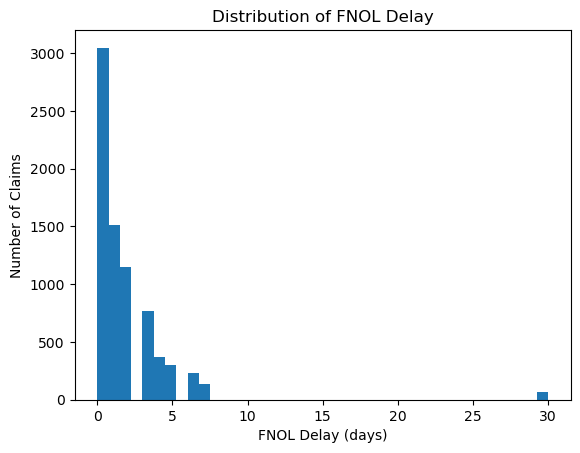

In [101]:
# FNOL Delay

plt.figure()
plt.hist(claims_claim_level["FNOL_Delay_Days"].dropna(), bins=40)
plt.xlabel("FNOL Delay (days)")
plt.ylabel("Number of Claims")
plt.title("Distribution of FNOL Delay")
plt.show()


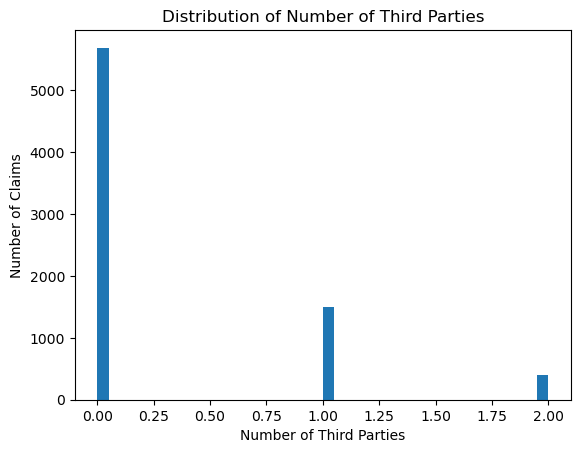

In [102]:
# Num_Third_Parties

plt.figure()
plt.hist(claims_claim_level["Num_Third_Parties"].dropna(), bins=40)
plt.xlabel("Number of Third Parties")
plt.ylabel("Number of Claims")
plt.title("Distribution of Number of Third Parties")
plt.show()


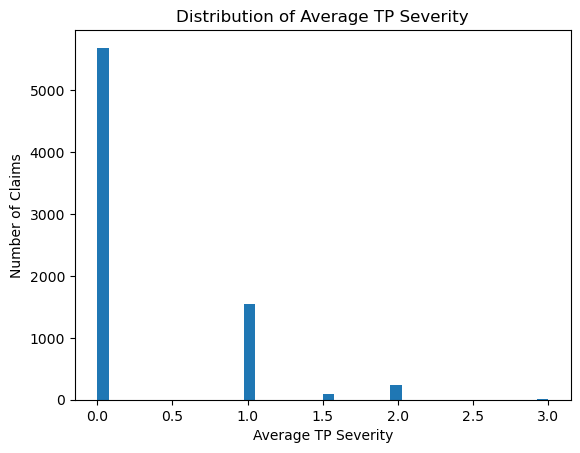

In [103]:
# Avg_TP_Severity

plt.figure()
plt.hist(claims_claim_level["Avg_TP_Severity"].dropna(), bins=40)
plt.xlabel("Average TP Severity")
plt.ylabel("Number of Claims")
plt.title("Distribution of Average TP Severity")
plt.show()

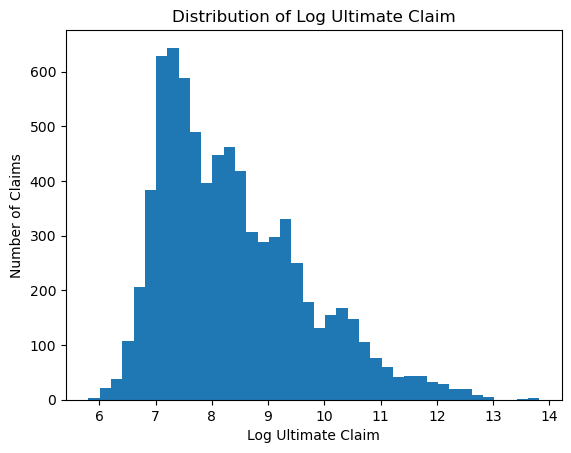

In [104]:
# log_Estimated_Claim_Amount

plt.figure()
plt.hist(claims_claim_level["log_Ultimate_Claim_Amount"].dropna(), bins=40)
plt.xlabel("Log Ultimate Claim")
plt.ylabel("Number of Claims")
plt.title("Distribution of Log Ultimate Claim")
plt.show()

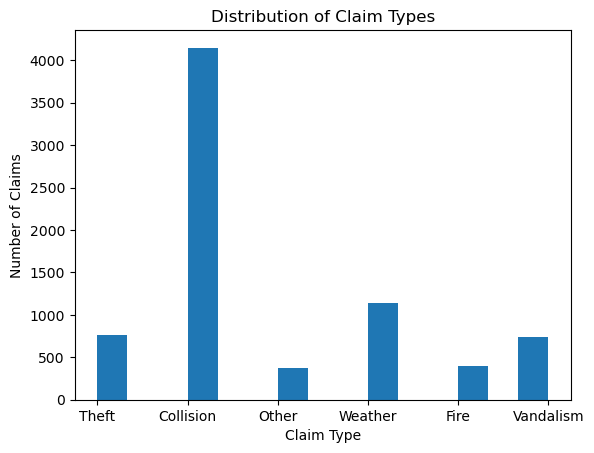

In [105]:
# Claim_Type


plt.figure()
plt.hist(claims_claim_level["Claim_Type"].dropna(), bins=15)
plt.xlabel("Claim Type")
plt.ylabel("Number of Claims")
plt.title("Distribution of Claim Types")
plt.show()

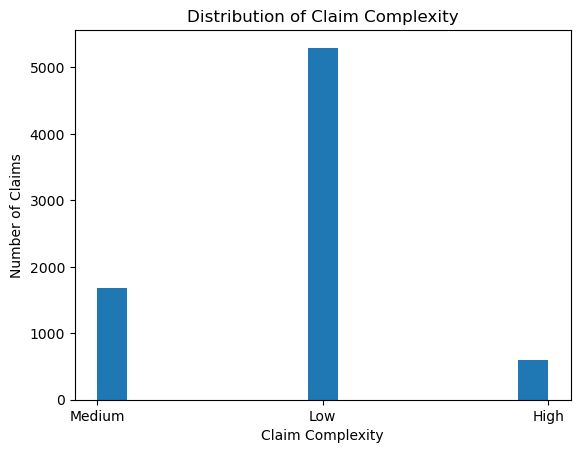

In [106]:
# Claim_Complexity	

plt.figure()
plt.hist(claims_claim_level["Claim_Complexity"].dropna(), bins=15)
plt.xlabel("Claim Complexity")
plt.ylabel("Number of Claims")
plt.title("Distribution of Claim Complexity")
plt.show()

#### Bivariate Analysis (Feature vs Target Variable)

This tells if there is a strong or weak relationship between a feature and the target variable.

Target = "log_Ultimate_Claim_Amount"

In [107]:
y = "log_Ultimate_Claim_Amount"
claims_claim_level[y].min()

5.808142489980444

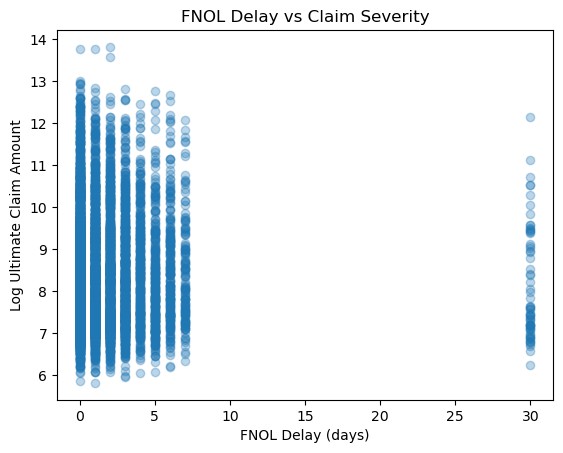

'Most claims are reported quickly btwn 0 to 7 days. \n    FNOL delay is heavily skewed towards small values\n    There is no tight linear relationship\n    Very late reporting is rare and often signals complexity or dispute'

In [108]:
# FNOL delay days vs Target

y = "log_Ultimate_Claim_Amount"

plt.figure()
plt.scatter(
    claims_claim_level["FNOL_Delay_Days"],
    claims_claim_level[y],
    alpha=0.3
)
plt.xlabel("FNOL Delay (days)")
plt.ylabel("Log Ultimate Claim Amount")
plt.title("FNOL Delay vs Claim Severity")
plt.show()


'''Most claims are reported quickly btwn 0 to 7 days. 
    FNOL delay is heavily skewed towards small values
    There is no tight linear relationship
    Very late reporting is rare and often signals complexity or dispute'''

In [109]:
# Binary vs target

claims_claim_level.groupby("Has_Third_Party")[y].mean()
claims_claim_level.groupby("Fraud_Flag")[y].mean()
claims_claim_level.groupby("Litigation_Flag")[y].mean()


''' This calculates the average severity of each group to know which is more associated with higher ultimate costs'''

''' Claims flagged for litigation indicates a higher ultimate cost'''


' Claims flagged for litigation indicates a higher ultimate cost'

##### Categorical Variable Vs Target

<Figure size 640x480 with 0 Axes>

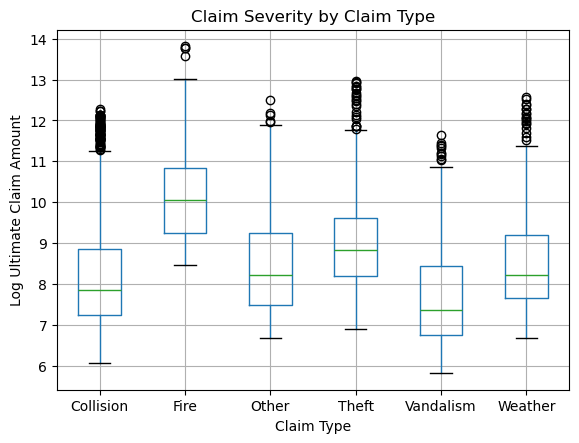

' Box plot shows clear differences in claim severity across claim typesc, with fire and theft \n    exhibiting higher medians and greater variability, confirming claim type as a strong\n    predictor of severity'

In [110]:

# Claim Type vs Target

plt.figure()
claims_claim_level.boxplot(
    column=y,
    by="Claim_Type"
)
plt.title("Claim Severity by Claim Type")
plt.suptitle("")
plt.xlabel("Claim Type")
plt.ylabel("Log Ultimate Claim Amount")
plt.show()

''' Box plot shows clear differences in claim severity across claim typesc, with fire and theft 
    exhibiting higher medians and greater variability, confirming claim type as a strong
    predictor of severity'''

<Figure size 640x480 with 0 Axes>

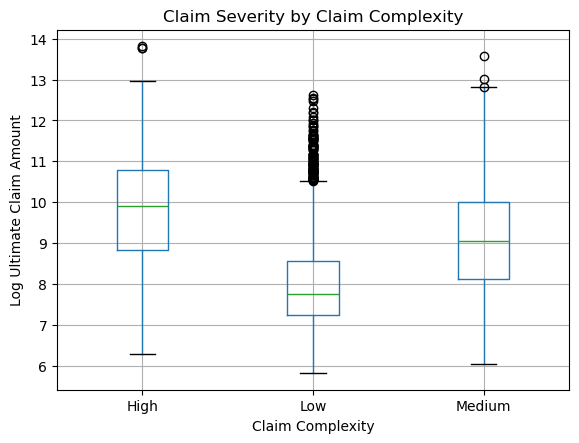

In [111]:
# Claim_complexity

plt.figure()
claims_claim_level.boxplot(
    column=y,
    by="Claim_Complexity"
)
plt.title("Claim Severity by Claim Complexity")
plt.suptitle("")
plt.xlabel("Claim Complexity")
plt.ylabel("Log Ultimate Claim Amount")
plt.show()


# There is a clear increase low - medium - high 
# This makes it a strong predictor of severity
    

<Figure size 640x480 with 0 Axes>

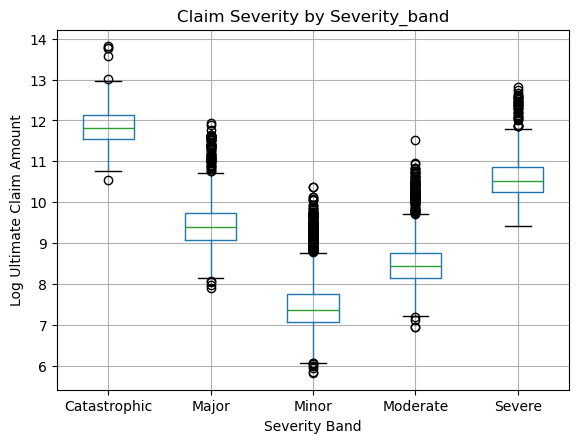

In [112]:
# Severity Band

plt.figure()
claims_claim_level.boxplot(
    column=y,
    by="Severity_Band"
)
plt.title("Claim Severity by Severity_band")
plt.suptitle("")
plt.xlabel("Severity Band")
plt.ylabel("Log Ultimate Claim Amount")
plt.show()

# There is strong ordering where severity increases consistently at each level: Minor - Morderate - Major - Severe - Catastrophic
# This has a natural order and would support ordinal encoding
# 



#### Multivariate Analysis

This step computes correlations among key features and the target to assess linear relationships, detect redundancy and identify potential multicollinearity before modelling.

In [113]:
claims_claim_level.head(2)

,Claim_ID,Policy_ID,Accident_Date,FNOL_Date,Claim_Type,Claim_Complexity,Fraud_Flag,Litigation_Flag,Estimated_Claim_Amount,Ultimate_Claim_Amount,...,Status,Num_Third_Parties,Max_TP_Severity,Avg_TP_Severity,log_Ultimate_Claim_Amount,FNOL_Delay_Days,Has_Third_Party,Severe_Third_Party,Accident_Month,Accident_Weekend
0,CLM30000,POL14506,2019-12-19,2019-12-19,Theft,Medium,0,1,5243,2808.0,...,settled,1,1.0,1.0,7.940584,0,1,0,12,0
1,CLM30001,POL14338,2018-12-30,2018-12-31,Collision,Low,0,0,3934,2952.0,...,settled,0,0.0,0.0,7.990577,1,0,0,12,1


In [114]:
claims_claim_level.columns

Index(['Claim_ID', 'Policy_ID', 'Accident_Date', 'FNOL_Date', 'Claim_Type',
       'Claim_Complexity', 'Fraud_Flag', 'Litigation_Flag',
       'Estimated_Claim_Amount', 'Ultimate_Claim_Amount', 'Severity_Band',
       'Settlement_Date', 'Status', 'Num_Third_Parties', 'Max_TP_Severity',
       'Avg_TP_Severity', 'log_Ultimate_Claim_Amount', 'FNOL_Delay_Days',
       'Has_Third_Party', 'Severe_Third_Party', 'Accident_Month',
       'Accident_Weekend'],
      dtype='object')

In [115]:
claims_level_cat = claims_claim_level[["Claim_Type", "Claim_Complexity", "Severity_Band"]]

In [116]:
claims_level_cat

,Claim_Type,Claim_Complexity,Severity_Band
0,Theft,Medium,Minor
1,Collision,Low,Minor
2,Other,Medium,Catastrophic
3,Weather,Low,Minor
4,Theft,Low,Minor
...,...,...,...
7570,Fire,Low,Major
7571,Collision,Low,Minor
7572,Theft,Low,Minor
7573,Fire,Medium,Moderate


#### Categorical Variables and the Target

Relationships between categorical variables and the target are visualised using heatmaps to provide an interpretable measure of association. 

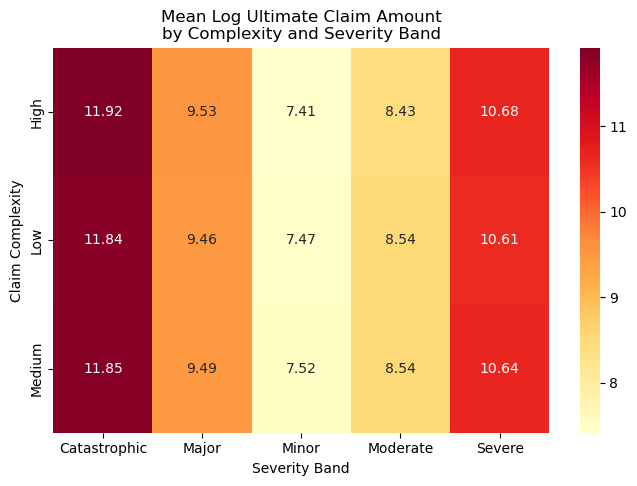

In [117]:
#  Relationship btwn Claim_Complexity, Severity_Band and log_umtimate_claim_amount
# Shows joint effect of two categorical variables on the target

pivot_mean = claims_claim_level.pivot_table(
    values="log_Ultimate_Claim_Amount",
    index="Claim_Complexity",
    columns="Severity_Band",
    aggfunc="mean"
)

plt.figure(figsize=(8,5))
sns.heatmap(pivot_mean, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Mean Log Ultimate Claim Amount\nby Complexity and Severity Band")
plt.xlabel("Severity Band")
plt.ylabel("Claim Complexity")
plt.show()


# With each severity band, mean increases slightly with complexity
# Severity band is highly informative at FNOl
# The heat map shows that severity band is the primary driver of claim complexity
# They both capture different dimensions and will be retained for modelling

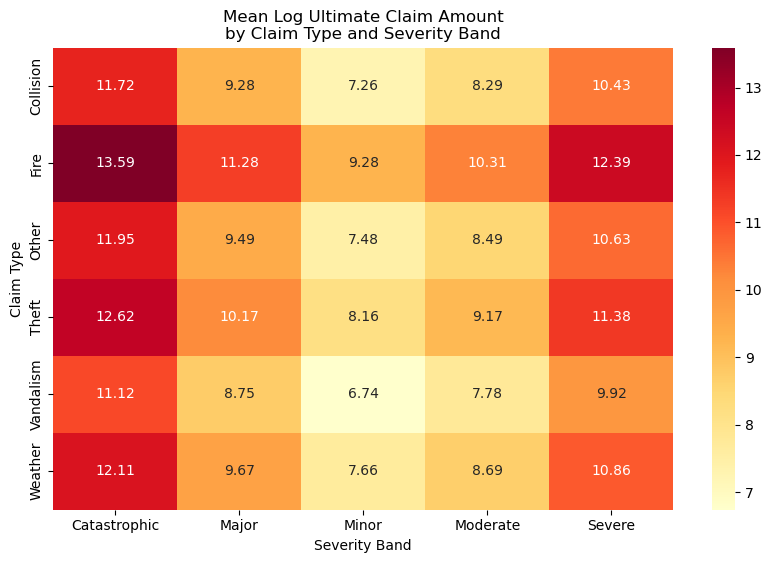

In [118]:
#  Relationship btwn Claim_Type, Severity_Band and log_umtimate_claim_amount
# Shows joint effect of two categorical variables on the target

pivot_ct_sb = claims_claim_level.pivot_table(
    values="log_Ultimate_Claim_Amount",
    index="Claim_Type",
    columns="Severity_Band",
    aggfunc="mean"
)

plt.figure(figsize=(10,6))
sns.heatmap(pivot_ct_sb, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Mean Log Ultimate Claim Amount\nby Claim Type and Severity Band")
plt.xlabel("Severity Band")
plt.ylabel("Claim Type")
plt.show()


# Fire claims are most severe while vandalism is least severe, meaning that fire claims cause extensive damage
# Severity band and claim type capture different dimensions not overlapping

#### Numerical Variables and the Target

Relationships between numeric predictors and the target to help inspect linear association risk and multicollinearity risks. 

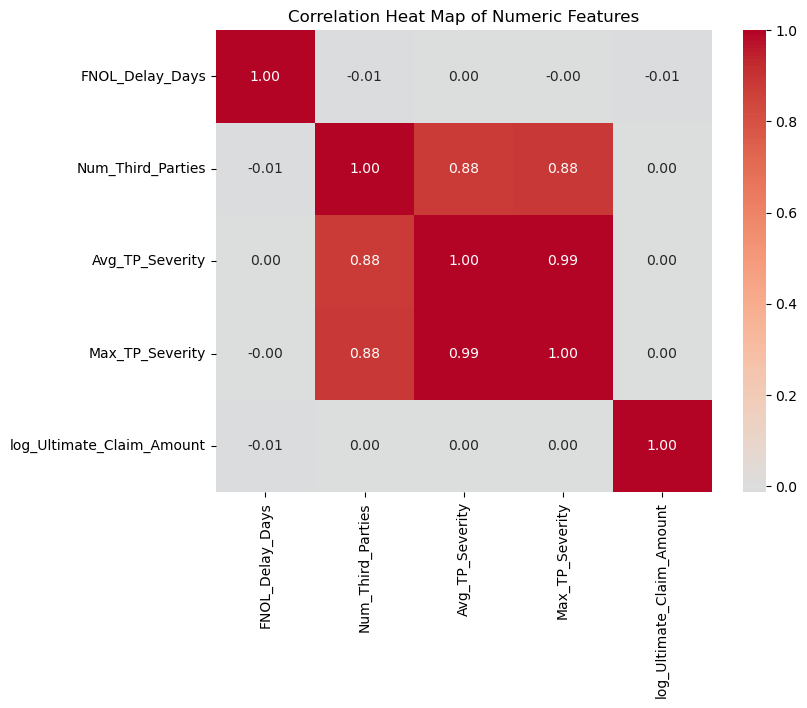

In [119]:
# 4 numeric variables and the target visualised using correlation heatmap
# Shows pearson correlations between numeric features

numeric_features = [
    "FNOL_Delay_Days",
    "Num_Third_Parties",
    "Avg_TP_Severity",
    "Max_TP_Severity",
    "log_Ultimate_Claim_Amount"
]

corr_matrix = claims_claim_level[numeric_features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Heat Map of Numeric Features")
plt.show()



# Values close to +1 = strong positive relationship
# Values close to 0 = no linear relationship
# Values close to -1 = Strong negative relationship

# There is weak linear relationship btwn any numeric variable and the target
# Strong correlations were detected among the numeric features. This signals multicollinearity risks.
# Based on this, features to keep are "FNOL_Delay_Days" and "Num_Third_Parties"

#### Statistical Ananlysis to explor Multicollinearity

Variance Inflation Factor (VIF) : This tells if a variable is redundant compared to others by quantifying how much information overlaps. 

1. VIF = 1  no redundancy
2. VIF > 5  concerning
3. VIF > 10 severe multicollinearity


In [120]:
# Detecting severity of multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

numeric_vars = [
    "FNOL_Delay_Days",
    "Num_Third_Parties",
    "Avg_TP_Severity",
    "Max_TP_Severity"
]

X = claims_claim_level[numeric_vars].dropna()

vif_df = pd.DataFrame()
vif_df["Feature"] = X.columns
vif_df["VIF"] = [
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

vif_df


# FNOL_Days and Num_Third_Parties will be dropped

,Feature,VIF
0,FNOL_Delay_Days,1.058494
1,Num_Third_Parties,5.818945
2,Avg_TP_Severity,109.798901
3,Max_TP_Severity,114.832745
